In [1]:
import torch
import numpy as np
import pandas as pd
import librosa as lr
import matplotlib.pyplot as plt

from librosa import display as lrd
import IPython.display as ipd

from torch.utils.data import DataLoader, ConcatDataset, random_split
from asteroid.data import TimitDataset
from tqdm import tqdm

from asteroid.data.utils import find_audio_files, cut_or_pad

%load_ext autoreload
%autoreload 2

In [2]:
def show_wav(wav, sr=16000):
    if type(wav) == str:
        wav, sr = lr.load(wav)
        
    lrd.waveplot(wav, sr=sr)
    plt.show()
    ipd.display(ipd.Audio(wav, rate=sr))

In [3]:
TIMIT_CACHE_DIR = '/import/vision-eddydata/dm005_tmp/mixed_wavs_asteroid'

In [4]:
train_snrs = [-25, -20, -15, -10, -5, 0, 5, 10, 15]
test_snrs = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15]

In [5]:
timit_train_misc = TimitDataset.load_with_cache(
    '../../../datasets/TIMIT', '../../../datasets/noises-train',
    cache_dir=TIMIT_CACHE_DIR, snrs=train_snrs, root_seed=42, prefetch_mixtures=False,
    dset_name='train-misc', subset='train', track_duration=48000)

Preparing datasets: 100%|██████████| 9/9 [00:00<00:00, 10.70it/s]


In [6]:
# timit_train_drones = TimitDataset.load_with_cache(
#     '../../../datasets/TIMIT', '../../../datasets/noises-train-drones',
#     cache_dir=TIMIT_CACHE_DIR, snrs=train_snrs, root_seed=42, prefetch_mixtures=False,
#     mixtures_per_clean=5, dset_name='train-drones',
#     subset='train', track_duration=48000)

In [8]:
timit_test_drones = TimitDataset.load_with_cache(
    '../../../datasets/TIMIT', '../../../datasets/noises-test-drones',
    cache_dir=TIMIT_CACHE_DIR, snrs=test_snrs, dset_name='test-drones',
    subset='test', root_seed=68)

Load samples: 100%|██████████| 33600/33600 [01:18<00:00, 426.23it/s] 

Track lengths stats: total 1659729040, mean 49396.69761904762, median 47514.0, min 17511, max 121140
Tracks in total: 33600
Total audio duration: 28:48:53


In [9]:
def train_val_split(ds, val_fraction=0.1, random_seed=42):
    assert val_fraction > 0 and val_fraction < 0.5
    len_train = int(len(ds) * (1 - val_fraction))
    len_val = len(ds) - len_train
    return random_split(ds, [len_train, len_val], generator=torch.Generator().manual_seed(random_seed))

In [10]:
train_set, val_set = train_val_split(timit_train_misc)

In [11]:
BATCH_SIZE = 32
NUM_WORKERS = 10

train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=True,
)

val_loader = DataLoader(
    val_set,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=True,
)

#train_loader_test = DataLoader(train_set, shuffle=True, batch_size=8, num_workers=NUM_WORKERS, drop_last=True)

In [12]:
from torch import optim
from torch_lr_finder import LRFinder
from pytorch_lightning import Trainer, loggers as pl_loggers
from asteroid_filterbanks.transforms import mag
from asteroid.engine import System
from asteroid.losses import singlesrc_neg_sisdr

from asteroid import DCUNet, DCCRNet

def sisdr_loss_wrapper(est_target, target):
    return singlesrc_neg_sisdr(est_target.squeeze(1), target).mean()


In [13]:
dcunet20 = DCUNet("DCUNet-20", fix_length_mode="trim")
dcunet20_opt = optim.Adam(dcunet20.parameters(), lr=1e-7, weight_decay=1e-6)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.33E-04


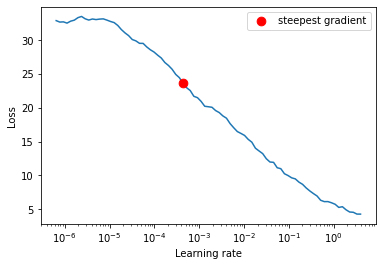

In [11]:
#lr_finder = LRFinder(dcunet20, dcunet20_opt, sisdr_loss_wrapper, device="cuda")
#lr_finder.range_test(train_loader_test, end_lr=10, num_iter=100)
#lr_finder.plot()
#lr_finder.reset()

In [15]:
dcunet20_sched = optim.lr_scheduler.OneCycleLR(dcunet20_opt, 0.03, epochs=10, steps_per_epoch=len(train_loader))
scheduler = {'scheduler': dcunet20_sched, 'interval': 'step'}

In [16]:
system = System(dcunet20, dcunet20_opt, sisdr_loss_wrapper, train_loader, val_loader, scheduler)

In [17]:
logger = pl_loggers.TensorBoardLogger('logs', name='TIMIT-drones-DCUNet-20-onecycle', version='v3')
trainer = Trainer(max_epochs=10, gpus=-1, accelerator='dp', logger=logger)
trainer.fit(system)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type   | Params
---------------------------------
0 | model | DCUNet | 3.5 M 
---------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params


/homes/dm005/conda_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: `training_step` must be implemented to be used with the Lightning Trainer
  warnings.warn(*args, **kwargs)
/homes/dm005/conda_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

1

In [18]:
dcunet20_serialized = dcunet20.serialize()
torch.save(dcunet20_serialized, 'dcunet_20_onecycle_v3.pt')

## Training UNetGAN

In [10]:
import pytorch_lightning as pl
import torch.nn.functional as F
from collections import OrderedDict

from asteroid.masknn import UNetGANGenerator, UNetGANDiscriminator

def _unsqueeze_to_3d(x):
    """Normalize shape of `x` to [batch, n_chan, time]."""
    if x.ndim == 1:
        return x.reshape(1, 1, -1)
    elif x.ndim == 2:
        return x.unsqueeze(1)
    else:
        return x

class UNetGAN(pl.LightningModule):

    def __init__(
        self,
        mse_weight: float = 20,
        lr_g: float = 1e-3,
        lr_d: float = 1e-3,
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()

        # networks
        self.generator = UNetGANGenerator()
        self.discriminator = UNetGANDiscriminator()

    def forward(self, z):
        return self.generator(_unsqueeze_to_3d(z))

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        mix, clean = batch
        mix = _unsqueeze_to_3d(mix)
        clean = _unsqueeze_to_3d(clean)

        # train generator
        if optimizer_idx == 0:

            enh = self.generator(mix)
            disc_vals = self.discriminator(mix, enh)
            
            fake = torch.zeros(*disc_vals.size())
            fake = fake.type_as(disc_vals)
            
            mse_loss = F.mse_loss(clean, enh)
            adv_loss = -self.adversarial_loss(disc_vals, fake)
            
            lm = self.hparams.mse_weight
            g_loss = adv_loss + lm * mse_loss
        
            tqdm_dict = {'g_loss': g_loss}
            output = OrderedDict({
                'loss': g_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

        # train discriminator
        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples

            enh = self.generator(mix).detach()
            clean_disc_vals = self.discriminator(mix, clean)
            enh_disc_vals = self.discriminator(mix, enh)
            
            # how well can it label as real?
            valid = torch.ones(*clean_disc_vals.size())
            valid = valid.type_as(clean_disc_vals)
            
            fake = torch.zeros(*enh_disc_vals.size())
            fake = fake.type_as(enh_disc_vals)

            real_loss = self.adversarial_loss(clean_disc_vals, valid)
            fake_loss = self.adversarial_loss(enh_disc_vals, fake)
        
            d_loss = real_loss + fake_loss
            tqdm_dict = {'d_loss': d_loss}
            output = OrderedDict({
                'loss': d_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

    def configure_optimizers(self):
        lr_g = self.hparams.lr_g
        lr_d = self.hparams.lr_d

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr_g)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        return [opt_g, opt_d], []

#     def on_epoch_end(self):
#         z = self.validation_z.type_as(self.generator.model[0].weight)

#         # log sampled images
#         sample_imgs = self(z)
#         grid = torchvision.utils.make_grid(sample_imgs)
#         self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

In [14]:
unetgan_module = UNetGAN(lr_g=2e-4, lr_d=2e-4)

In [16]:
trainer = Trainer(max_epochs=100, gpus=[1,3], accelerator='ddp',
                  resume_from_checkpoint='logs/UNetGAN-misc-continue/v1/checkpoints/epoch=68-step=322712.ckpt')
trainer.fit(unetgan_module, train_loader, val_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/homes/dm005/conda_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)
initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/2


KeyboardInterrupt: 

In [11]:
logger = pl_loggers.TensorBoardLogger('logs', name='TIMIT-misc-DCCRN', version='v2')
model2 = DCCRNet("DCCRN-CL")
optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)
system2 = System(model2, optimizer2, sisdr_loss_wrapper, train_loader, val_loader)

In [12]:
trainer = Trainer(max_epochs=30, gpus=1, logger=logger)
trainer.fit(system2)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | DCCRNet | 3.7 M 
----------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params


/homes/dm005/conda_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: `training_step` must be implemented to be used with the Lightning Trainer
  warnings.warn(*args, **kwargs)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
dccrn_serialized = model2.serialize()

In [14]:
torch.save(dccrn_serialized, 'dccrn_v2.pt')

In [15]:
from asteroid.masknn.wavenet import UNetGANGenerator

In [18]:
gen = UNetGANGenerator()

In [19]:
sum(p.numel() for p in gen.parameters())


4373378